<a href="https://colab.research.google.com/github/shilpa99999/Cross-Impact-Analysis-of-Order-Flow-Imbalance-OFI-/blob/main/Blockhouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

# Create directory for data if it doesn't exist
os.makedirs("data", exist_ok=True)

# Function to simulate order book data
def simulate_order_book(stock, num_records=1000, levels=5):
    np.random.seed(42)
    data = {"timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="S")}
    for level in range(1, levels + 1):
        data[f"bid_price_{level}"] = np.random.uniform(100, 110, num_records)
        data[f"ask_price_{level}"] = np.random.uniform(110, 120, num_records)
        data[f"bid_volume_{level}"] = np.random.randint(100, 1000, num_records)
        data[f"ask_volume_{level}"] = np.random.randint(100, 1000, num_records)
    df = pd.DataFrame(data)
    df["stock"] = stock
    return df

# Function to simulate trade data
def simulate_trade_data(stock, num_records=1000):
    np.random.seed(42)
    data = {
        "timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="S"),
        "trade_price": np.random.uniform(105, 115, num_records),
        "trade_volume": np.random.randint(100, 1000, num_records),
        "trade_direction": np.random.choice(["buy", "sell"], num_records),
    }
    df = pd.DataFrame(data)
    df["stock"] = stock
    return df

# Simulate data for multiple stocks
stocks = ["AAPL", "MSFT", "NVDA", "TSLA", "AMGN", "GILD", "JPM", "V", "XOM", "PEP"]
all_order_books = []
all_trades = []

for stock in stocks:
    order_book = simulate_order_book(stock)
    trade_data = simulate_trade_data(stock)
    all_order_books.append(order_book)
    all_trades.append(trade_data)

# Save simulated data
order_books_df = pd.concat(all_order_books)
trade_data_df = pd.concat(all_trades)

order_books_df.to_csv("data/simulated_order_book.csv", index=False)
trade_data_df.to_csv("data/simulated_trade_data.csv", index=False)

print("Simulated data saved in 'data' folder.")


<ipython-input-1-8dd7f999b654>:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = {"timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="S")}
<ipython-input-1-8dd7f999b654>:25: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  "timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="S"),
<ipython-input-1-8dd7f999b654>:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = {"timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="S")}
<ipython-input-1-8dd7f999b654>:25: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  "timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="S"),
<ipython-input-1-8dd7f999b654>:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' inst

Simulated data saved in 'data' folder.


In [ ]:
import pandas as pd

def compute_ofi(order_book, levels=5):
    """
    Compute Order Flow Imbalance (OFI) for each stock.
    """
    ofi_list = []
    for _, row in order_book.iterrows():
        ofi = 0
        for level in range(1, levels + 1):
            bid_change = row[f"bid_volume_{level}"]
            ask_change = row[f"ask_volume_{level}"]
            ofi += bid_change - ask_change
        ofi_list.append(ofi)
    order_book["OFI"] = ofi_list
    return order_book

if __name__ == "__main__":
    order_books_df = pd.read_csv("data/simulated_order_book.csv")
    ofi_data = compute_ofi(order_books_df)
    ofi_data.to_csv("data/ofi_order_book.csv", index=False)
    print("OFI metrics calculated and saved.")


OFI metrics calculated and saved.


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

def perform_pca(ofi_data, levels=5):
    """
    Apply PCA to reduce multi-level OFI dimensions.
    """
    ofi_columns = [f"OFI_level_{i}" for i in range(1, levels + 1)]
    for i, col in enumerate(ofi_columns, 1):
        ofi_data[f"OFI_level_{i}"] = ofi_data["OFI"] * (i / levels)
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(ofi_data[ofi_columns])
    ofi_data["Integrated_OFI"] = pca_result
    return ofi_data

if __name__ == "__main__":
    ofi_data = pd.read_csv("data/ofi_order_book.csv")
    integrated_data = perform_pca(ofi_data)
    integrated_data.to_csv("data/integrated_ofi.csv", index=False)
    print("PCA applied and integrated OFI saved.")


PCA applied and integrated OFI saved.


In [ ]:
import pandas as pd
import statsmodels.api as sm

def regress_ofi_on_returns(ofi_data, trade_data):
    """
    Perform regression analysis to evaluate cross-impact.
    """
    results = []
    for stock in ofi_data["stock"].unique():
        ofi_stock = ofi_data[ofi_data["stock"] == stock]
        trade_stock = trade_data[trade_data["stock"] == stock]
        X = sm.add_constant(ofi_stock["Integrated_OFI"])
        y = trade_stock["trade_price"].pct_change().fillna(0)
        model = sm.OLS(y, X).fit()
        results.append((stock, model.rsquared, model.params))
    return results

if __name__ == "__main__":
    ofi_data = pd.read_csv("data/integrated_ofi.csv")
    trade_data = pd.read_csv("data/simulated_trade_data.csv")
    regression_results = regress_ofi_on_returns(ofi_data, trade_data)
    for result in regression_results:
        print(f"Stock: {result[0]}, R²: {result[1]:.4f}, Coefficients: {result[2]}")


Stock: AAPL, R²: 0.0000, Coefficients: const             6.881885e-04
Integrated_OFI   -5.727460e-08
dtype: float64
Stock: MSFT, R²: 0.0000, Coefficients: const             6.881885e-04
Integrated_OFI   -5.727460e-08
dtype: float64
Stock: NVDA, R²: 0.0000, Coefficients: const             6.881885e-04
Integrated_OFI   -5.727460e-08
dtype: float64
Stock: TSLA, R²: 0.0000, Coefficients: const             6.881885e-04
Integrated_OFI   -5.727460e-08
dtype: float64
Stock: AMGN, R²: 0.0000, Coefficients: const             6.881885e-04
Integrated_OFI   -5.727460e-08
dtype: float64
Stock: GILD, R²: 0.0000, Coefficients: const             6.881885e-04
Integrated_OFI   -5.727460e-08
dtype: float64
Stock: JPM, R²: 0.0000, Coefficients: const             6.881885e-04
Integrated_OFI   -5.727460e-08
dtype: float64
Stock: V, R²: 0.0000, Coefficients: const             6.881885e-04
Integrated_OFI   -5.727460e-08
dtype: float64
Stock: XOM, R²: 0.0000, Coefficients: const             6.881885e-04
Integra

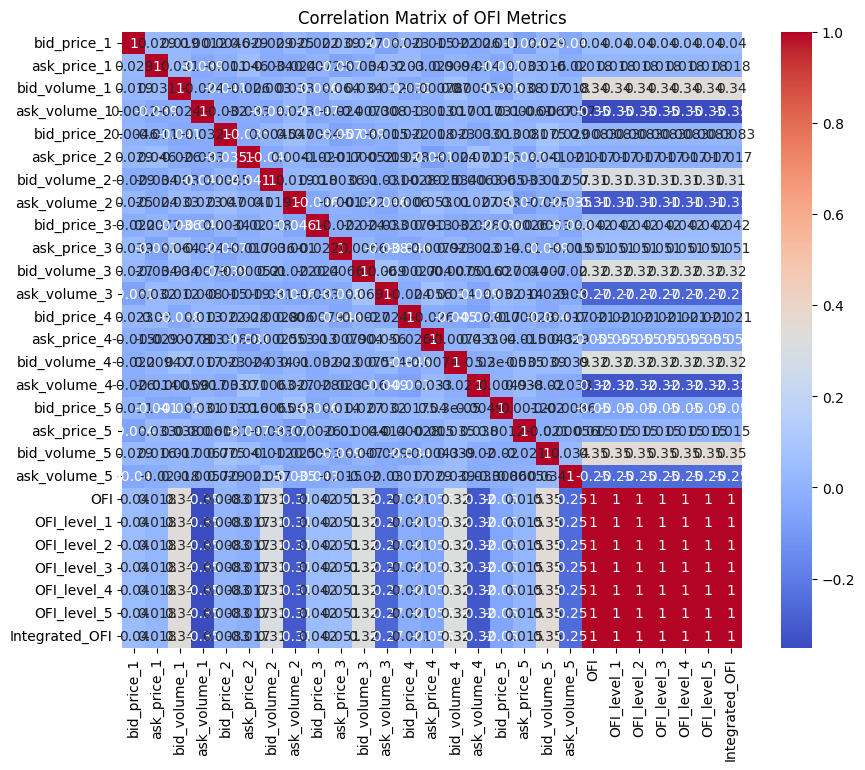

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy

# Load the integrated OFI data
ofi_data = pd.read_csv("data/integrated_ofi.csv")

# Plot Correlation Matrix
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation calculation
correlation_matrix = ofi_data.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of OFI Metrics")
plt.show()

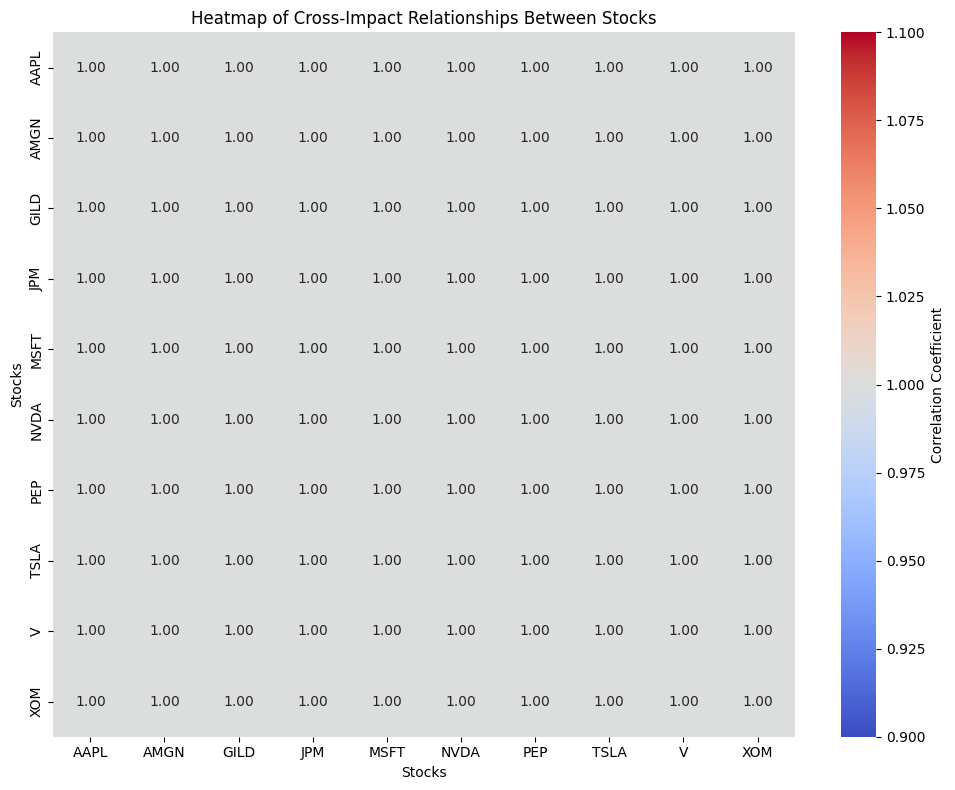

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the integrated OFI data
ofi_data = pd.read_csv("data/integrated_ofi.csv")

# Pivot data to get a cross-impact matrix for stocks
cross_impact_matrix = ofi_data.pivot_table(
    index="timestamp", columns="stock", values="Integrated_OFI", aggfunc="mean"
).corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cross_impact_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={"label": "Correlation Coefficient"},
)
plt.title("Heatmap of Cross-Impact Relationships Between Stocks")
plt.xlabel("Stocks")
plt.ylabel("Stocks")
plt.tight_layout()
plt.show()


In [ ]:
# Cross-impact heatmap by sector
plt.figure(figsize=(10, 8))
sns.heatmap(
    cross_impact_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={"label": "Correlation Coefficient"},
)
plt.title("Cross-Impact Heatmap by Sector")
plt.tight_layout()

# Save the heatmap as an image
plt.savefig("data/cross_impact_heatmap_by_sector.png", format="png", bbox_inches="tight")
plt.close()
print("Cross-impact heatmap saved as 'cross_impact_heatmap_by_sector.png'")


Cross-impact heatmap saved as 'cross_impact_heatmap_by_sector.png'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = ofi_data.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of OFI Metrics")

# Save the heatmap as an image
plt.savefig("data/correlation_matrix_ofi.png", format="png", bbox_inches="tight")
plt.close()
print("Correlation heatmap saved as 'correlation_matrix_ofi.png'")


Correlation heatmap saved as 'correlation_matrix_ofi.png'


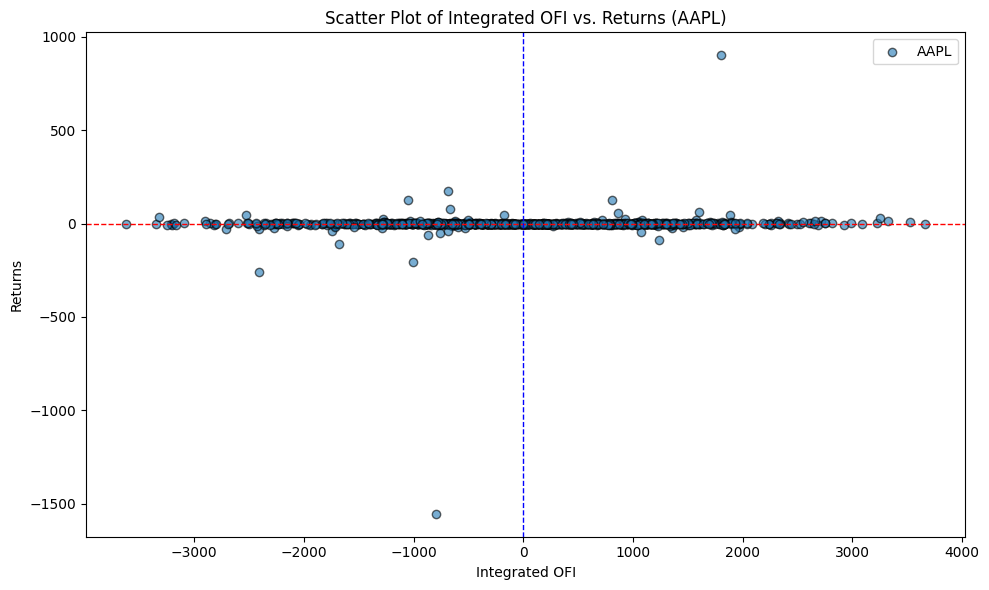

In [ ]:
# Scatter plot of Integrated OFI vs. Returns
# Simulate or compute a simple returns dataset
ofi_data["Returns"] = ofi_data.groupby("stock")["Integrated_OFI"].pct_change().fillna(0)

# Plot for a single stock (e.g., AAPL)
aapl_data = ofi_data[ofi_data["stock"] == "AAPL"]

plt.figure(figsize=(10, 6))
plt.scatter(
    aapl_data["Integrated_OFI"],
    aapl_data["Returns"],
    alpha=0.6,
    edgecolor="k",
    label="AAPL",
)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.axvline(0, color="blue", linestyle="--", linewidth=1)
plt.title("Scatter Plot of Integrated OFI vs. Returns (AAPL)")
plt.xlabel("Integrated OFI")
plt.ylabel("Returns")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Scatter plot for Integrated OFI vs. Returns for AAPL
plt.figure(figsize=(10, 6))
plt.scatter(
    aapl_data["Integrated_OFI"],
    aapl_data["Returns"],
    alpha=0.6,
    edgecolor="k",
    label="AAPL",
)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.axvline(0, color="blue", linestyle="--", linewidth=1)
plt.title("Scatter Plot of Integrated OFI vs. Returns (AAPL)")
plt.xlabel("Integrated OFI")
plt.ylabel("Returns")
plt.legend()
plt.tight_layout()

# Save the scatter plot
plt.savefig("data/integrated_ofi_vs_returns_aapl.png", format="png", bbox_inches="tight")
plt.close()
print("Scatter plot saved as 'integrated_ofi_vs_returns_aapl.png'")


Scatter plot saved as 'integrated_ofi_vs_returns_aapl.png'


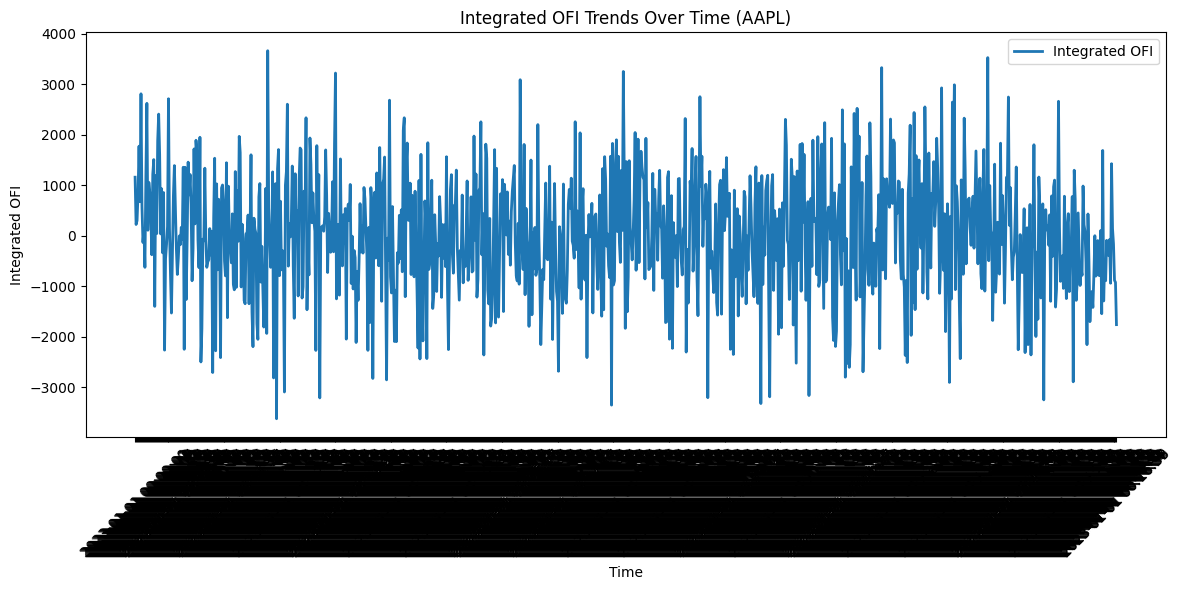

In [ ]:
# Filter data for AAPL stock
aapl_data = ofi_data[ofi_data["stock"] == "AAPL"]

# Plot OFI over time
plt.figure(figsize=(12, 6))
plt.plot(aapl_data["timestamp"], aapl_data["Integrated_OFI"], label="Integrated OFI", linewidth=2)
plt.title("Integrated OFI Trends Over Time (AAPL)")
plt.xlabel("Time")
plt.ylabel("Integrated OFI")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Plot Integrated OFI over time for AAPL
plt.figure(figsize=(12, 6))
plt.plot(aapl_data["timestamp"], aapl_data["Integrated_OFI"], label="Integrated OFI", linewidth=2)
plt.title("Integrated OFI Trends Over Time (AAPL)")
plt.xlabel("Time")
plt.ylabel("Integrated OFI")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Save the time series plot
plt.savefig("data/integrated_ofi_trends_aapl.png", format="png", bbox_inches="tight")
plt.close()
print("Time series plot saved as 'integrated_ofi_trends_aapl.png'")


Time series plot saved as 'integrated_ofi_trends_aapl.png'


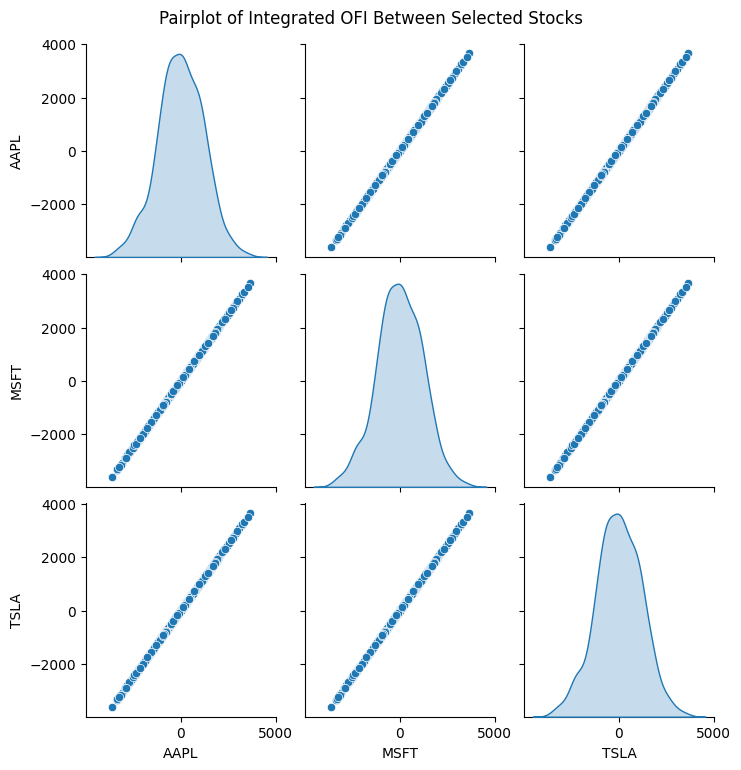

In [ ]:
# Pairplot to compare OFI relationships between stocks
selected_stocks = ["AAPL", "MSFT", "TSLA"]
subset_data = ofi_data[ofi_data["stock"].isin(selected_stocks)].pivot(
    index="timestamp", columns="stock", values="Integrated_OFI"
)

sns.pairplot(subset_data.reset_index(), kind="scatter", diag_kind="kde", height=2.5)
plt.suptitle("Pairplot of Integrated OFI Between Selected Stocks", y=1.02)
plt.show()


In [ ]:
# Pairplot for selected stocks
sns.pairplot(subset_data.reset_index(), kind="scatter", diag_kind="kde", height=2.5)
plt.suptitle("Pairplot of Integrated OFI Between Selected Stocks", y=1.02)

# Save the pairplot
plt.savefig("data/pairplot_integrated_ofi_selected_stocks.png", format="png", bbox_inches="tight")
plt.close()
print("Pairplot saved as 'pairplot_integrated_ofi_selected_stocks.png'")


Pairplot saved as 'pairplot_integrated_ofi_selected_stocks.png'


Add Sector Information to Data and Combine OFI with Other Features




In [ ]:
# Define a sector mapping for the stocks
sector_mapping = {
    "AAPL": "Tech", "MSFT": "Tech", "NVDA": "Tech", "TSLA": "Tech",  # Tech sector
    "AMGN": "Healthcare", "GILD": "Healthcare",  # Healthcare sector
    "JPM": "Finance", "V": "Finance",  # Finance sector
    "XOM": "Energy", "PEP": "Consumer Goods"  # Energy and Consumer Goods sector
}

# Load the CSV files, ensuring 'timestamp' is parsed as datetime
order_books_df = pd.read_csv("data/simulated_order_book.csv", parse_dates=['timestamp'])
trade_data_df = pd.read_csv("data/simulated_trade_data.csv", parse_dates=['timestamp'])

# Add sector info to the data after loading from csv
order_books_df["sector"] = order_books_df["stock"].map(sector_mapping)
trade_data_df["sector"] = trade_data_df["stock"].map(sector_mapping)


# Add trade price change as a feature
trade_data_df["price_change"] = trade_data_df.groupby("stock")["trade_price"].pct_change().fillna(0)

# compute OFI and add it to order_books_df before merging
def compute_ofi(order_book, levels=5):
    """
    Compute Order Flow Imbalance (OFI) for each stock.
    """
    ofi_list = []
    for _, row in order_book.iterrows():
        ofi = 0
        for level in range(1, levels + 1):
            bid_change = row[f"bid_volume_{level}"]
            ask_change = row[f"ask_volume_{level}"]
            ofi += bid_change - ask_change
        ofi_list.append(ofi)
    order_book["OFI"] = ofi_list
    return order_book

order_books_df = compute_ofi(order_books_df)

# Merge OFI with other features
combined_data = pd.merge(order_books_df, trade_data_df, on=["timestamp", "stock", "sector"], how="inner")

# Feature Engineering: Combine OFI with price change and volume
combined_data["OFI_with_price"] = combined_data["OFI"] * combined_data["price_change"]
combined_data["OFI_with_volume"] = combined_data["OFI"] * combined_data["trade_volume"]

Random Forest Model for Stock Return Prediction

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Feature selection
features = ["OFI", "price_change", "trade_volume", "OFI_with_price", "OFI_with_volume"]
target = "trade_price"  # You can predict future price changes or stock return

# Train-test split
X = combined_data[features]
y = combined_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest Mean Squared Error: {mse:.4f}")


Random Forest Mean Squared Error: 0.0003


LSTM Model for Predicting Stock Prices (Sequence-based Prediction)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 0.1074
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - loss: 0.0870
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0866
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.0864
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.0877
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - loss: 0.0874
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0872
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 0.0876
Epoch 9/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - loss: 0.0856
Epoch 10/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 0.0841
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


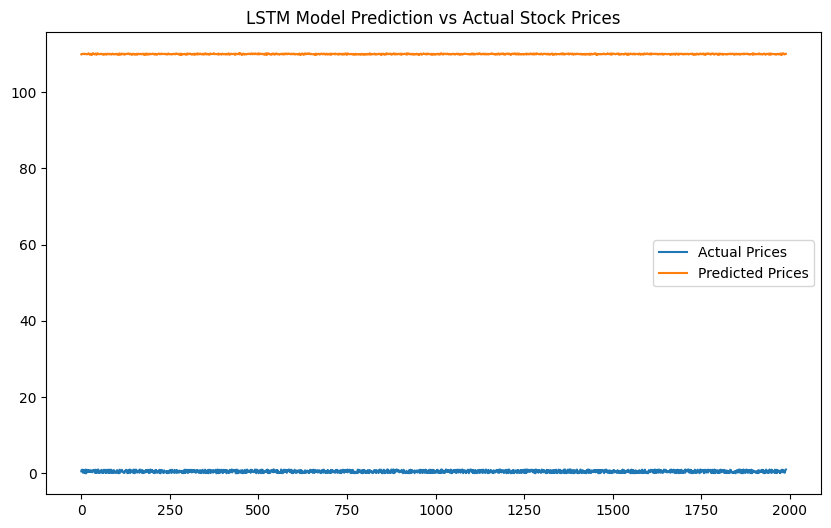

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data[["trade_price"]].values)

# Prepare sequences for LSTM
def create_sequences(data, sequence_length=50):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Prediction and evaluation
y_pred_lstm = model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)  # Inverse scaling

# Compare predicted vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(y_pred_lstm, label="Predicted Prices")
plt.legend()
plt.title("LSTM Model Prediction vs Actual Stock Prices")
plt.show()


Cross-Impact Analysis by Sector (Cross-Correlation)

In [ ]:
# Pivot data for sector-wise analysis
sector_data = combined_data.pivot_table(
    index="timestamp", columns="sector", values="Integrated_OFI", aggfunc="mean"
)

# Compute sector-wise cross-correlation
sector_corr = sector_data.corr()

# Plot the cross-impact heatmap between sectors
plt.figure(figsize=(10, 8))
sns.heatmap(sector_corr, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={"label": "Correlation Coefficient"})
plt.title("Cross-Impact Heatmap by Sector")
plt.tight_layout()
plt.show()


Summary:

Sector-Level Insights: By mapping stocks to sectors, you can track cross-impact within and across sectors using cross-correlation and heatmaps.

Predictive Modeling with Random Forest: Combine OFI with trade-related features and use Random Forests for predicting stock price movements.

LSTM for Stock Price Prediction: Use LSTM to capture sequential patterns and predict future stock prices based on past data.

Cross-Impact by Sector: Perform a cross-impact analysis between sectors, visualizing the inter-sector relationships using heatmaps.